In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0111

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.0077
Average validation loss: 0.6542847752571106
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - loss: 0.0077 - val_loss: 0.6543
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - loss: 0.0049 - val_loss: 0.6543
Average validation loss: 0.586850643157959
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - loss: 0.0049 - val_loss: 0.6206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 745ms/step - loss: 0.0035 - val_loss: 0.6206
Average validation loss: 0.4344102144241333
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 753ms/step - loss: 0.0035 - val_loss: 0.5585
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segfor

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 833ms/step - loss: 6.9278e-07
Average validation loss: 0.13747266307473183
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 849ms/step - loss: 6.9278e-07 - val_loss: 0.1375
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 872ms/step - loss: 6.4853e-07 - val_loss: 0.1375
Average validation loss: 0.08062905259430408
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 886ms/step - loss: 6.4853e-07 - val_loss: 0.1091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 853ms/step - loss: 6.2514e-07 - val_loss: 0.1091
Average validation loss: 0.11533809453248978
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 866ms/step - loss: 6.2514e-07 - val_loss: 0.1111
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 823ms/step - loss: 6.0778e-07 - val_loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 809ms/step - loss: 2.7192e-07
Average validation loss: 0.03862899231414
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 821ms/step - loss: 2.7192e-07 - val_loss: 0.0386
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - loss: 2.7229e-07 - val_loss: 0.0386
Average validation loss: 0.05748786901434263
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 829ms/step - loss: 2.7229e-07 - val_loss: 0.0481
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 842ms/step - loss: 2.5939e-07 - val_loss: 0.0481
Average validation loss: 0.06072054492930571
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 853ms/step - loss: 2.5939e-07 - val_loss: 0.0523
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 874ms/step - loss: 2.4873e-07 - val_loss: 0.0523
Average validation loss: 0.06015230963627497
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 884ms/step - loss: 2.4873e-07 - val_loss: 0.0542
Epoch 5/10
1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 893ms/step - loss: 1.6176e-07
Average validation loss: 0.06541823223233223
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 904ms/step - loss: 1.6176e-07 - val_loss: 0.0654
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 821ms/step - loss: 1.4912e-07 - val_loss: 0.0654
Average validation loss: 0.03508882783353329
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 832ms/step - loss: 1.4912e-07 - val_loss: 0.0503
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 818ms/step - loss: 1.4607e-07 - val_loss: 0.0503
Average validation loss: 0.040189079474657774
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 829ms/step - loss: 1.4607e-07 - val_loss: 0.0469
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 817ms/step - loss: 1.4291

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 813ms/step - loss: 1.0344e-07
Average validation loss: 0.0529125964269042
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 823ms/step - loss: 1.0344e-07 - val_loss: 0.0529
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 795ms/step - loss: 1.0144e-07 - val_loss: 0.0529
Average validation loss: 0.01997214462608099
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 805ms/step - loss: 1.0144e-07 - val_loss: 0.0364
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 796ms/step - loss: 9.4653e-08 - val_loss: 0.0364
Average validation loss: 0.01677179681137204
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 807ms/step - loss: 9.4653e-08 - val_loss: 0.0299
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weig

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 792ms/step - loss: 2.2817e-07
Average validation loss: 0.02329178697740038
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 802ms/step - loss: 2.2817e-07 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 782ms/step - loss: 1.7947e-07 - val_loss: 0.0233
Average validation loss: 0.016918996271366876
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 792ms/step - loss: 1.7947e-07 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 802ms/step - loss: 1.5895e-07 - val_loss: 0.0201
Average validation loss: 0.014355862513184547
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 813ms/step - loss: 1.5895e-07 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 773ms/step - loss: 2.2266e-07
Average validation loss: 0.04598692930303514
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 783ms/step - loss: 2.2266e-07 - val_loss: 0.0460
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 779ms/step - loss: 1.8634e-07 - val_loss: 0.0460
Average validation loss: 0.05671382928267121
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - loss: 1.8634e-07 - val_loss: 0.0514
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 767ms/step - loss: 1.5728e-07 - val_loss: 0.0514
Average validation loss: 0.08583249365910887
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 777ms/step - loss: 1.5728e-07 - val_loss: 0.0628
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 125s 786ms/step - loss: 1.4716e-07 - val_loss: 0.0628
Average validation loss: 0.0509988724719733
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 797ms/step - loss: 1.4716e-07 - val_loss: 0.0599
Epoch 5/

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 778ms/step - loss: 2.4420e-07
Average validation loss: 0.02277080315010001
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 789ms/step - loss: 2.4420e-07 - val_loss: 0.0228
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 783ms/step - loss: 1.9826e-07 - val_loss: 0.0228
Average validation loss: 0.023777265295696754
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - loss: 1.9826e-07 - val_loss: 0.0233
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 797ms/step - loss: 1.6816e-07 - val_loss: 0.0233
Average validation loss: 0.021471631868431967
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 809ms/step - loss: 1.6816e-07 - val_loss: 0.0227
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 779ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 766ms/step - loss: 1.0784e-07
Average validation loss: 0.030059881774442538
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 777ms/step - loss: 1.0784e-07 - val_loss: 0.0301
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 805ms/step - loss: 9.9779e-08 - val_loss: 0.0301
Average validation loss: 0.027304500873599733
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 816ms/step - loss: 9.9779e-08 - val_loss: 0.0287
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 938ms/step - loss: 8.9873e-08 - val_loss: 0.0287
Average validation loss: 0.027214548949684416
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 949ms/step - loss: 8.9873e-08 - val_loss: 0.0282
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1D

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 778ms/step - loss: 7.0064e-08
Average validation loss: 0.029703325824812055
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 790ms/step - loss: 7.0064e-08 - val_loss: 0.0297
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 785ms/step - loss: 5.8795e-08 - val_loss: 0.0297
Average validation loss: 0.02822781028226018
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 796ms/step - loss: 5.8795e-08 - val_loss: 0.0290
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 790ms/step - loss: 5.2396e-08 - val_loss: 0.0290
Average validation loss: 0.029636870487593114
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 801ms/step - loss: 5.2396e-08 - val_loss: 0.0292
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 798ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 777ms/step - loss: 6.0071e-08
Average validation loss: 0.02968681280294226
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 6.0071e-08 - val_loss: 0.0297
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 793ms/step - loss: 5.2794e-08 - val_loss: 0.0297
Average validation loss: 0.03665914826302065
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 804ms/step - loss: 5.2794e-08 - val_loss: 0.0332
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 793ms/step - loss: 4.9877e-08 - val_loss: 0.0332
Average validation loss: 0.03419635362095303
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 804ms/step - loss: 4.9877e-08 - val_loss: 0.0335
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 230s 793ms/step - loss: 4.5424e-08 - val_loss: 0.0335
Average validation loss: 0.028782528850974307
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 804ms/step - loss: 4.5424e-08 - val_loss: 0.0323
Sa

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 777ms/step - loss: 7.3320e-08
Average validation loss: 0.026668149838224055
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 7.3320e-08 - val_loss: 0.0267
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 809ms/step - loss: 5.6008e-08 - val_loss: 0.0267
Average validation loss: 0.022555900877341627
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 820ms/step - loss: 5.6008e-08 - val_loss: 0.0246
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 856ms/step - loss: 4.8195e-08 - val_loss: 0.0246
Average validation loss: 0.03740437612868845
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 867ms/step - loss: 4.8195e-08 - val_loss: 0.0289
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 265s 835ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 774ms/step - loss: 2.0662e-07
Average validation loss: 0.04037134873215109
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - loss: 2.0662e-07 - val_loss: 0.0404
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 785ms/step - loss: 1.9060e-07 - val_loss: 0.0404
Average validation loss: 0.03352719459993144
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 795ms/step - loss: 1.9060e-07 - val_loss: 0.0369
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 783ms/step - loss: 1.6316e-07 - val_loss: 0.0369
Average validation loss: 0.028110512900942315
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 794ms/step - loss: 1.6316e-07 - val_loss: 0.0340
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 788ms/step - loss: 1.4870e-07
Average validation loss: 0.024198570694231116
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 799ms/step - loss: 1.4870e-07 - val_loss: 0.0242
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 782ms/step - loss: 1.2644e-07 - val_loss: 0.0242
Average validation loss: 0.021707961937257398
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 793ms/step - loss: 1.2644e-07 - val_loss: 0.0230
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 286s 792ms/step - loss: 1.0685e-07 - val_loss: 0.0230
Average validation loss: 0.018078882199673293
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 803ms/step - loss: 1.0685e-07 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 786ms/step - loss: 1.2366e-07
Average validation loss: 0.033420867948987305
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 797ms/step - loss: 1.2366e-07 - val_loss: 0.0334
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 798ms/step - loss: 1.1520e-07 - val_loss: 0.0334
Average validation loss: 0.021923530207156244
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 808ms/step - loss: 1.1520e-07 - val_loss: 0.0277
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 345s 792ms/step - loss: 1.0329e-07 - val_loss: 0.0277
Average validation loss: 0.02439579114717263
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 803ms/step - loss: 1.0329e-07 - val_loss: 0.0266
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 461s 7

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 792ms/step - loss: 5.6026e-08
Average validation loss: 0.020460535620804875
160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 802ms/step - loss: 5.6026e-08 - val_loss: 0.0205
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 782ms/step - loss: 5.0582e-08 - val_loss: 0.0205
Average validation loss: 0.021843890780291985
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 792ms/step - loss: 5.0582e-08 - val_loss: 0.0212
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 788ms/step - loss: 4.4706e-08 - val_loss: 0.0212
Average validation loss: 0.017213576886570083
160/160 ━━━━━━━━━━━━━━━━━━━━ 383s 798ms/step - loss: 4.4706e-08 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 510s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 787ms/step - loss: 7.7995e-08
Average validation loss: 0.02560869029199239
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 798ms/step - loss: 7.7995e-08 - val_loss: 0.0256
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 787ms/step - loss: 6.1363e-08 - val_loss: 0.0256
Average validation loss: 0.024388703708100364
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 798ms/step - loss: 6.1363e-08 - val_loss: 0.0250
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 479s 797ms/step - loss: 5.3692e-08 - val_loss: 0.0250
Average validation loss: 0.020937459905981087
200/200 ━━━━━━━━━━━━━━━━━━━━ 481s 808ms/step - loss: 5.3692e-08 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 198s 826ms/step - loss: 7.0094e-08
Average validation loss: 0.02023057444336397
240/240 ━━━━━━━━━━━━━━━━━━━━ 201s 837ms/step - loss: 7.0094e-08 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 400s 828ms/step - loss: 5.8101e-08 - val_loss: 0.0202
Average validation loss: 0.02013304738405471
240/240 ━━━━━━━━━━━━━━━━━━━━ 402s 840ms/step - loss: 5.8101e-08 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 596s 808ms/step - loss: 4.9540e-08 - val_loss: 0.0202
Average validation loss: 0.021827916918846314
240/240 ━━━━━━━━━━━━━━━━━━━━ 599s 819ms/step - loss: 4.9540e-08 - val_loss: 0.0207
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 795s 81

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.16075673937797547, 0.05715582389384508, 0.04601551206161579, 0.033299335020128634, 0.02471338536031545, 0.024256842629984024, 0.037155190701596445, 0.02968785241634275, 0.033115436632984455, 0.03599021756206639, 0.048187199373626054, 0.05341137175075711, 0.03457430098923699, 0.03992059018167281, 0.03071301356760968, 0.025442368984331377, 0.024315629259271557, 0.023064357081761352]
std_val_losses =  [0.14163180026604993, 0.038189490226316916, 0.013642765996311193, 0.011697057323140293, 0.010521715842412686, 0.00948540019857046, 0.017191914731017544, 0.007832131158277637, 0.005801843674044527, 0.006088659784408622, 0.01651217431609261, 0.0264477351266643, 0.007367690759264333, 0.013523418036414197, 0.008105543386012076, 0.007948512355063674, 0.004946758129169264, 0.004430710237818888]


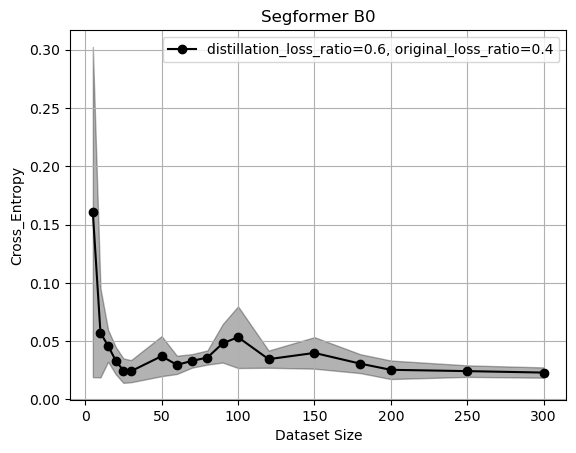

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()